In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
from datetime import datetime, timedelta

In [2]:
#we are only going to use 2021 data, otherwise the computer will run too slow
def divvy_data_locator(years, months, start_station, end_station):
    df_divvy = pd.read_csv('divvy_trip_history_201909-202108.csv')
    df_divvy = df_divvy.loc[(df_divvy.year.isin(years)) & (df_divvy.month.isin(months)) & ((df_divvy.start_station_name == start_station) | (df_divvy.end_station_name == end_station)),:]
    return df_divvy


In [3]:
total_raw = divvy_data_locator(years = range(2019,2022),
                               months= range(1,13),
                               start_station = 'Michigan Ave & Oak St',
                               end_station = 'Michigan Ave & Oak St' )

C:\Users\TF2020\AppData\Local\Temp/ipykernel_2652/2272659162.py:1: DtypeWarning: Columns (3,8,10) have mixed types.Specify dtype option on import or set low_memory=False.
  total_raw = divvy_data_locator(years = range(2019,2022),


In [4]:
sum(total_raw['start_station_id'].isnull() & total_raw['end_station_id'].isnull())
#it seems like we don't have any missing value here

0

In [5]:
#Change the data type for certain columns
total_raw['started_at'] = pd.to_datetime(total_raw['started_at'])
total_raw['ended_at'] = pd.to_datetime(total_raw['ended_at'])

#We could collect the hour data so the prediction can be more appliable to the operation.
total_raw['started_hr'] = total_raw['started_at'].dt.hour
total_raw['ended_hr'] = total_raw['ended_at'].dt.hour

<AxesSubplot:xlabel='started_hr', ylabel='Count'>

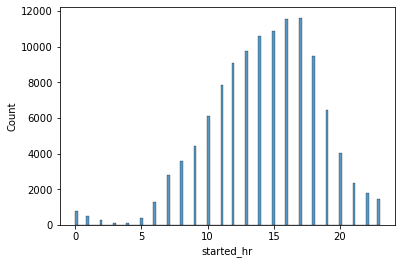

In [6]:
sns.histplot(data = total_raw, x = 'started_hr')

<AxesSubplot:xlabel='started_at', ylabel='Count'>

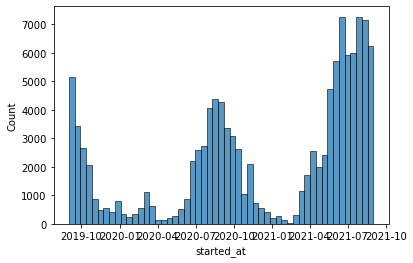

In [7]:
sns.histplot(data = total_raw, x = 'started_at')

<AxesSubplot:xlabel='day_of_week', ylabel='Count'>

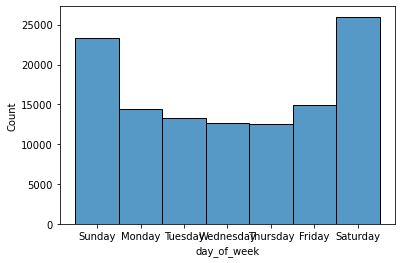

In [8]:
sns.histplot(data = total_raw, x = 'day_of_week')

In [9]:
total_raw = total_raw.dropna(subset= ['start_station_id','end_station_id'],how= 'all')
total_raw['date'] = pd.to_datetime(total_raw['date'])
#drop the row if both start station and end station are missing.

In [10]:
full_date = pd.DataFrame(pd.date_range('2019-09-01','2021-09-1',freq='h'), columns= ['time']).iloc[:-1,:]

full_date['date'] = pd.to_datetime(full_date['time'].dt.date)
full_date['time'] = full_date['time'].dt.hour
full_date['day_of_week'] = full_date['date'].dt.strftime('%A')


In [11]:
#we need number for both start and arrival 
start_total_data = total_raw.loc[total_raw.start_station_name == 'Michigan Ave & Oak St',:].value_counts(subset=['date','started_hr','day_of_week']).reset_index()
start_total_data.rename(columns={'started_hr':'time'}, inplace= True)
start_total_data = full_date.merge(start_total_data, how= 'outer')
start_total_data['trip'] = 'start'

arrival_total_data = total_raw.loc[total_raw.end_station_name == 'Michigan Ave & Oak St',:].value_counts(subset=['date','ended_hr','day_of_week']).reset_index()
arrival_total_data.rename(columns={'ended_hr':'time'}, inplace= True)
arrival_total_data = full_date.merge(arrival_total_data, how= 'outer')
arrival_total_data[['trip']] = 'arrival'

total_data = pd.concat([start_total_data,arrival_total_data],axis=0).reset_index(drop= True)

total_data.rename(columns={0:'Number_of_rider'}, inplace = True)
total_data = total_data.fillna(0)

### Weather Data Scraping (Skip it if you have weather data ready)

In [41]:
#set up scraping enviroment
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from webdrivermanager.chrome import ChromeDriverManager

ChromeDriverManager.download_and_install
ChromeDriverManager.get_latest_version
driver = webdriver.Chrome(r"C:\Users\TF2020\AppData\Local\rasjani\WebDriverManager\bin\chromedriver.exe")

In [42]:
#make sure we know what date we need
all_dates = pd.date_range('2019-09-01','2021-09-01',freq='d')

def get_url(search):
    url_temp = 'https://www.wunderground.com/history/daily/KMDW/date/{}'
    url = url_temp.format(search)
    return url

records = []
missing_date = []
for day in all_dates :
    url = get_url(day)
    driver.get(url)

    time.sleep(1)

    soup = BeautifulSoup(driver.page_source, 'html.parser')
    try:
        result_parent = soup.find('table', {'aria-labelledby':'History observation'})

        results = result_parent.find('tbody')
        for row in results.find_all('tr'):
            time_hr = row.find('span',{'class':'ng-star-inserted'}).text

            record_parent = row.find_all('span',{'class':'wu-value wu-value-to'})
            temperature = record_parent[0].text
            humidity = record_parent[2].text
            wind_speed = record_parent[3].text
            precip = record_parent[-1].text
            condition = row.find_all('span',{'class':'ng-star-inserted'})[-1].text
            
            record = (time_hr, temperature, humidity, wind_speed, precip, condition, day)

            records.append(record)

    except: 
        missing_date.append(day)



#Put all the scraping parts together
weather_data = pd.DataFrame(records, columns= ['time','temperature','humidity','wind_speed','precipation','condition','date'])

weather_data.to_csv('weather_raw.csv')
    

In [66]:
#There are some extra records in the same hour, we are only going to keep one
weather_data = pd.read_csv('weather_raw.csv', index_col= 0)
weather_data['date'] = pd.to_datetime(weather_data['date'])
weather_data['time'] = pd.to_datetime(weather_data['time'])
weather_data['time'] = weather_data['time'].dt.hour


#Find the duplicate that is next to each other.
time_temp = weather_data.time
dup_list = []
for i in range(len(time_temp)) : 
    if (i == 0) or i == len(time_temp) or time_temp[i] != time_temp[i-1]: 
        dup_list.append(i)

weather_data = weather_data.iloc[dup_list,:]
weather_data = weather_data.reset_index(drop= True)

#The original website put some previous day data into the next day, and all of these are happened on 10 to 11PM
time_temp = weather_data.time
for i in range(len(time_temp)-1):
    if (time_temp[i] == 23 or time_temp[i] == 22) & (time_temp[i+1] == 0 or time_temp[i+1] == 1) & (weather_data.date[i+1] == weather_data.date[i]):
        weather_data.date[i] -= timedelta(days=1)

weather_data.to_csv('weather_clean.csv')

C:\Users\TF2020\AppData\Local\Temp/ipykernel_648/2894279829.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data.date[i] -= timedelta(days=1)


### Skip it if you already have Divvy_weather_data.csv

In [75]:
weather_data = pd.read_csv('weather_clean.csv', index_col= 0)
weather_data['date'] = pd.to_datetime(weather_data['date'])
weather_data = weather_data.reset_index(drop= True)

In [76]:
df_beach_weather = pd.read_csv('Beach_Weather_Stations.csv')

#celsius to fahrenheit
df_beach_weather['Air Temperature'] = df_beach_weather['Air Temperature'] * 9/5 + 32
#mm to inch
df_beach_weather['Interval Rain'] = df_beach_weather['Interval Rain']/25.4
#meter per hour to mph 2.237
df_beach_weather['Wind Speed'] = df_beach_weather['Wind Speed']*2.237

In [77]:
#transform some date time into date and hour
df_beach_weather['Measurement Timestamp'] = pd.to_datetime(df_beach_weather['Measurement Timestamp'])
df_beach_weather['hr'] = df_beach_weather['Measurement Timestamp'].dt.hour
df_beach_weather['Date'] = pd.to_datetime(df_beach_weather['Measurement Timestamp'].dt.date)


In [78]:
#Get the record from the missing date(which happened during data sraping process)
print(missing_date)

Target_date = missing_date[0]
record_2020_11_08 = df_beach_weather.loc[(df_beach_weather['Station Name'] == 'Oak Street Weather Station') & (df_beach_weather['Date'] == Target_date),['hr','Air Temperature','Humidity','Wind Speed','Interval Rain', 'Precipitation Type','Date']]
record_2020_11_08 = record_2020_11_08.sort_values(by = ['hr'])
record_2020_11_08= record_2020_11_08.reset_index(drop= True) 
#No precipitation, the weather is consider fair that day
record_2020_11_08['Precipitation Type'] = 'Fair'
record_2020_11_08.columns = weather_data.columns

[Timestamp('2020-11-08 00:00:00', freq='D')]


In [120]:
#prepare a backaup weather dataset
all_dates = pd.date_range('2019-09-01','2021-09-1',freq='d')
record_oak_street = df_beach_weather.loc[(df_beach_weather['Station Name'] == 'Oak Street Weather Station') & (df_beach_weather['Date'].isin(all_dates)),['hr','Air Temperature','Humidity','Wind Speed','Interval Rain', 'Precipitation Type','Date']]
record_oak_street = record_oak_street.sort_values(by = ['Date','hr'])
record_oak_street= record_oak_street.reset_index(drop= True) 
record_oak_street = record_oak_street.rename(columns={
                                        'Date':'date',
                                        'hr':'time'})

In [181]:
#Combine the missing date data we found out during the scraping process
Divvy_weather_data = pd.concat([weather_data,record_2020_11_08],axis=0).reset_index(drop= True)

#After concat we still have some missing time data using
temp = full_date[['date','time']].merge(Divvy_weather_data, how='left') 
missing_time = temp[temp.temperature.isnull()][['date','time']]
missing_time = missing_time.merge(record_oak_street, how='left') #using left look up to fill out the missing value
missing_time['Precipitation Type'] = np.NaN
missing_time = missing_time.fillna('missing')
missing_time = missing_time[['time','Air Temperature','Humidity','Wind Speed','Interval Rain', 'Precipitation Type','date']]
missing_time.columns = weather_data.columns

#Combine the record again
Divvy_weather_data = pd.concat([Divvy_weather_data,missing_time],axis=0).reset_index(drop= True)
Divvy_weather_data = Divvy_weather_data.sort_values(by = ['date','time'],ignore_index = True)

#We might still have some time that is off the record from both weather station and the website
for i in range(len(Divvy_weather_data)):
    if Divvy_weather_data.condition[i] == 'missing':
        try: #using their nearest record 
            Divvy_weather_data.loc[i,'temperature'] = Divvy_weather_data.temperature[i+1]
            Divvy_weather_data.loc[i,'humidity'] = Divvy_weather_data.humidity[i+1]
            Divvy_weather_data.loc[i,'wind_speed'] = Divvy_weather_data.wind_speed[i+1]
            Divvy_weather_data.loc[i,'precipation'] = Divvy_weather_data.precipation[i +1]
            Divvy_weather_data.loc[i,'condition'] = Divvy_weather_data.condition[i + 1]
            if Divvy_weather_data.condition[i + 1] == 'missing':
                Divvy_weather_data.loc[i,'temperature'] = Divvy_weather_data.temperature[i-1]
                Divvy_weather_data.loc[i,'humidity'] = Divvy_weather_data.humidity[i-1]
                Divvy_weather_data.loc[i,'wind_speed'] = Divvy_weather_data.wind_speed[i-1]
                Divvy_weather_data.loc[i,'precipation'] = Divvy_weather_data.precipation[i-1]
                Divvy_weather_data.loc[i,'condition'] = Divvy_weather_data.condition[i-1]

        except:
            Divvy_weather_data.loc[i,'temperature'] = Divvy_weather_data.temperature[i+3]
            Divvy_weather_data.loc[i,'humidity'] = Divvy_weather_data.humidity[i+3]
            Divvy_weather_data.loc[i,'wind_speed'] = Divvy_weather_data.wind_speed[i+3]
            Divvy_weather_data.loc[i,'precipation'] = Divvy_weather_data.precipation[i+3]
            Divvy_weather_data.loc[i,'condition'] = Divvy_weather_data.condition[i+3]

In [182]:
#We are going to remove windy from the condition sicne the wind speed can tell the differnece
Divvy_weather_data['condition'] = Divvy_weather_data['condition'].str.split(' / ', expand= True)[0]
Divvy_weather_data['condition'] = Divvy_weather_data['condition'].str.replace('Light ', '')
Divvy_weather_data['condition'] = Divvy_weather_data['condition'].str.replace('Freezing ', '')
Divvy_weather_data['condition'] = Divvy_weather_data['condition'].str.replace(' ', '_')
Divvy_weather_data.to_csv('Divvy_weather_data.csv')

## Machine Learning (Time Series Forecasting)

In [12]:
#we need import holiday package so it can label whether that day is holiday for us
import holidays

US_holiday = holidays.UnitedStates()
total_data.date[0] in US_holiday
total_data['holiday'] = pd.Series(total_data.date).apply(lambda x : x in US_holiday)
total_data['holiday_detail'] = pd.Series(total_data.date).apply(lambda x : US_holiday.get(x))

In [13]:
#combine both weather data and station record
Divvy_weather_data = pd.read_csv('Divvy_weather_data.csv', index_col= 0)
Divvy_weather_data['date'] = pd.to_datetime(Divvy_weather_data['date'])
total_data_weather = total_data.merge(Divvy_weather_data, left_on=['time','date'], right_on=['time','date'])

#get time ready for the machine learning
total_data_weather['date'] +=  pd.to_timedelta(total_data_weather['time'], unit='h') 
total_data_weather = total_data_weather.drop(columns = ['time'])



In [18]:
import tensorflow as tf

In [27]:
test_data = total_data_weather[total_data_weather['date']>'2021-08-24'].reset_index(drop= True)
train_data = total_data_weather[total_data_weather['date']<='2021-08-24'].reset_index(drop= True)